<a href="https://colab.research.google.com/github/iqra0908/Computer-Vision-for-Elementary-Education/blob/main/notebooks/Train_classifier_from_repo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone 'https://github.com/iqra0908/Computer-Vision-for-Elementary-Education.git/'

Cloning into 'Computer-Vision-for-Elementary-Education'...
remote: Enumerating objects: 214, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 214 (delta 2), reused 9 (delta 1), pack-reused 202
Receiving objects: 100% (214/214), 143.45 MiB | 21.09 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Updating files: 100% (66/66), done.


Computer-Vision-for-Elementary-Education/  sample_data/


In [ ]:
#!python train_transfer_classifier.py

torch:  1.13 ; cuda:  cu116
Traceback (most recent call last):
  File "train_transfer_classifier.py", line 67, in <module>
    train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
  File "/usr/local/lib/python3.8/dist-packages/torchvision/datasets/folder.py", line 309, in __init__
    super().__init__(
  File "/usr/local/lib/python3.8/dist-packages/torchvision/datasets/folder.py", line 144, in __init__
    classes, class_to_idx = self.find_classes(self.root)
  File "/usr/local/lib/python3.8/dist-packages/torchvision/datasets/folder.py", line 218, in find_classes
    return find_classes(directory)
  File "/usr/local/lib/python3.8/dist-packages/torchvision/datasets/folder.py", line 40, in find_classes
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
FileNotFoundError: [Errno 2] No such file or directory: 'data/toys_data/train'


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
### This is the code from the module... just putting it in one cell to see if the module works ok
### although the data directory is in a different location than the module 


##### Train model using transfer learning on ResNet50 architecture 
##### Saves model.pkl with name containing current date
##### Assumes dataset structure of images in directory with folder names = the classes
##### Heavily borrows from colab notebook from the class repo

import os
import urllib.request
import zipfile
import copy
import time
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime

# Some parameters being used
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

model_filename = 'resnet50classifier'+datetime.now().strftime("%Y%m%d")+'.pkl'
#data_dir = 'data/toys_data'
data_dir = '/content/gdrive/MyDrive/AIPI540/'
batch_size = 8
num_epochs = 25

# Set up transformations for training, validation, and test data
# For training data we will do resize to 224 * 224, randomized horizontal flipping, rotation, lighting effects, and normalization
# For test set we will do only center cropping to get to 224 * 224 and normalization

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(257),
		    transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
		    transforms.RandomVerticalFlip(),
	      transforms.ColorJitter(brightness=(0.0,1.5), contrast=(1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Create Datasets for training and validation sets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                          data_transforms['val'])
#test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])


# Create DataLoaders for training and validation sets

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)

# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader}

# Store size of training and validation sets
dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset)}

# Get class names associated with labels
class_names = train_dataset.classes
num_classes = len(class_names)
print(f'there are {num_classes} classes including {class_names}')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device is {device}')

# Instantiate pre-trained resnet
net = torchvision.models.resnet50(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in net.parameters():
    param.requires_grad = False

# Display a summary of the layers of the model and output shape after each layer
#summary(net,(images.shape[1:]),batch_size=batch_size,device="cpu")


# Get the number of inputs to final Linear layer
num_ftrs = net.fc.in_features
# Replace final Linear layer with a new Linear with the same number of inputs but just num_classes outputs,

net.fc = nn.Linear(num_ftrs, num_classes)

# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

def train_model(model, criterion, optimizer, dataloaders, scheduler, device, num_epochs=num_epochs):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

            # Step along learning rate scheduler when in train
            if phase == 'train':
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # If model performs better on val set, save weights as the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:3f}'.format(best_acc))

    # Load the weights from best model
    model.load_state_dict(best_model_wts)

    return model


# Learning rate scheduler - decay LR by a factor of 0.1 every 7 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the model
net = train_model(net, criterion, optimizer, dataloaders, lr_scheduler, device, num_epochs=25)

# Save the model
torch.save(net.state_dict(), 'content/Computer-Vision-for-Elementary-Education/models/resnet_transfer_model0208')


torch:  1.13 ; cuda:  cu116
there are 8 classes including ['cow', 'dog', 'goat', 'hen', 'horse', 'llama', 'pig', 'sheep']
Device is {device}


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 0/24
----------
train Loss: 2.1527 Acc: 0.1119
val Loss: 2.3544 Acc: 0.0968

Epoch 1/24
----------
train Loss: 1.9981 Acc: 0.2308
val Loss: 1.8993 Acc: 0.2903

Epoch 2/24
----------
train Loss: 1.8041 Acc: 0.2587
val Loss: 1.6588 Acc: 0.5806

Epoch 3/24
----------
train Loss: 1.7137 Acc: 0.4056
val Loss: 1.5234 Acc: 0.4839

Epoch 4/24
----------
train Loss: 1.5718 Acc: 0.4895
val Loss: 1.3147 Acc: 0.6452

Epoch 5/24
----------
train Loss: 1.4797 Acc: 0.5245
val Loss: 1.3023 Acc: 0.6452

Epoch 6/24
----------
train Loss: 1.3170 Acc: 0.6573
val Loss: 1.0480 Acc: 0.7742

Epoch 7/24
----------
train Loss: 1.2699 Acc: 0.6434
val Loss: 1.0284 Acc: 0.7419

Epoch 8/24
----------
train Loss: 1.2028 Acc: 0.7413
val Loss: 1.0313 Acc: 0.7742

Epoch 9/24
----------
train Loss: 1.1646 Acc: 0.7762
val Loss: 1.0201 Acc: 0.7419

Epoch 10/24
----------
train Loss: 1.1749 Acc: 0.7273
val Loss: 1.0517 Acc: 0.7742

Epoch 11/24
----------
train Loss: 1.1578 Acc: 0.7133
val Loss: 0.9972 Acc: 0.7742

Ep

RuntimeError: ignored

In [11]:
torch.save(net.state_dict(), '/content/Computer-Vision-for-Elementary-Education/models/resnet_transfer_model0208')

In [12]:
net.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

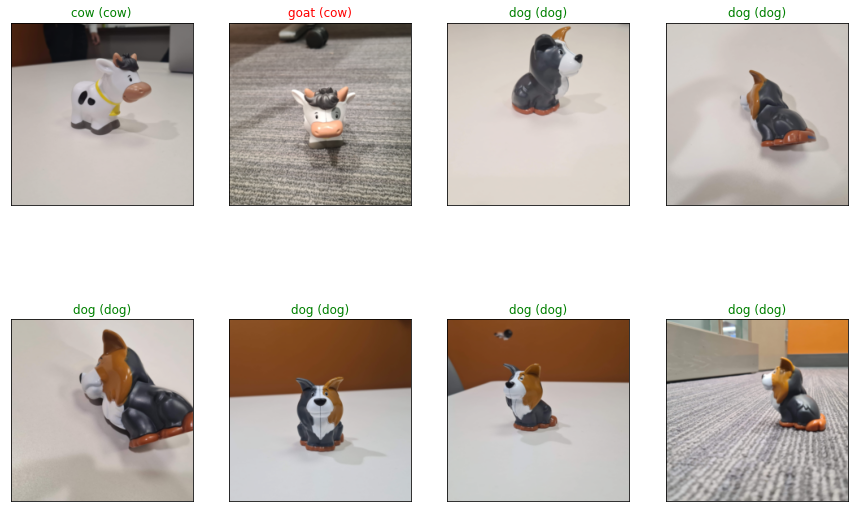

In [16]:
# Display a batch of predictions
def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = next(iter(val_loader))
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(net,val_loader,device)

In [15]:
# # loading model uploaded to repo
# model_path = 'models/resnet_transfer_model0207'
# #need to reconstruct top layer like above
# num_classes = 8
# net_loaded = torchvision.models.resnet50(pretrained=True)
# num_ftrs = net_loaded.fc.in_features
# net_loaded.fc = nn.Linear(num_ftrs, num_classes)

# net_loaded.load_state_dict(torch.load(model_path))
# model.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 